In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


10373 2593


In [ ]:
class LegoImagesDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# Dataset
dataset = load_dataset("Armaggheddon/lego_minifigure_captions", split="train")
full_dataset = LegoImagesDataset(dataset, transform=transform)

val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(len(train_ds), len(val_ds))

In [ ]:
# VAE
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.flatten_dim = 32 * 32 * 32

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 32, 32)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded_input = self.decoder_input(z)
        x_recon = self.decoder(decoded_input)
        return x_recon, mu, logvar


In [114]:
# Loss
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss


In [115]:
# Training
def train_vae(model, train_loader, val_loader, device, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x in train_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss = vae_loss(recon_x, x, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x in val_loader:
                x = x.to(device)
                recon_x, mu, logvar = model(x)
                val_loss += vae_loss(recon_x, x, mu, logvar).item()

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.2f} - Val Loss: {val_loss:.2f}")

In [116]:
# Show results
def show_result_vae(model, loader, device, n=8):
    model.eval()
    with torch.no_grad():
        images = next(iter(loader))
        images = images[:n].to(device)
        recon_images, _, _ = model(images)
        recon_images = recon_images.cpu()

    comparison = torch.cat([images.cpu(), recon_images])
    grid = torchvision.utils.make_grid(comparison, nrow=n, normalize=True)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Original vs Reconstructed")
    plt.show()

In [159]:
# Generate image
def generate_images(model, device, n=8):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, model.latent_dim).to(device)
        z = model.decoder_input(z)
        gen_images = model.decoder(z).cpu()

    grid = torchvision.utils.make_grid(gen_images, nrow=n, normalize=True)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("LEGO")
    plt.show()

In [137]:
vae = VAE(latent_dim=64)
train_vae(vae, train_loader, val_loader, device, epochs=25)

Epoch 1 - Train Loss: 129012834.21 - Val Loss: 16249979.70
Epoch 2 - Train Loss: 51093554.75 - Val Loss: 11146624.72
Epoch 3 - Train Loss: 39820176.52 - Val Loss: 9343273.80
Epoch 4 - Train Loss: 33571088.82 - Val Loss: 7890053.59
Epoch 5 - Train Loss: 28889255.53 - Val Loss: 7179154.70
Epoch 6 - Train Loss: 26092950.28 - Val Loss: 6478195.77
Epoch 7 - Train Loss: 24210976.48 - Val Loss: 6137631.84
Epoch 8 - Train Loss: 23051900.86 - Val Loss: 5813334.05
Epoch 9 - Train Loss: 21910362.72 - Val Loss: 5917518.96
Epoch 10 - Train Loss: 21409302.25 - Val Loss: 5505855.16
Epoch 11 - Train Loss: 20826918.25 - Val Loss: 5411143.67
Epoch 12 - Train Loss: 20490156.52 - Val Loss: 5394574.25
Epoch 13 - Train Loss: 20078395.37 - Val Loss: 5285822.88
Epoch 14 - Train Loss: 19747419.63 - Val Loss: 5215570.98
Epoch 15 - Train Loss: 19548232.08 - Val Loss: 5210592.52
Epoch 16 - Train Loss: 19360884.06 - Val Loss: 5137292.11
Epoch 17 - Train Loss: 19122545.49 - Val Loss: 5081956.74
Epoch 18 - Train Los

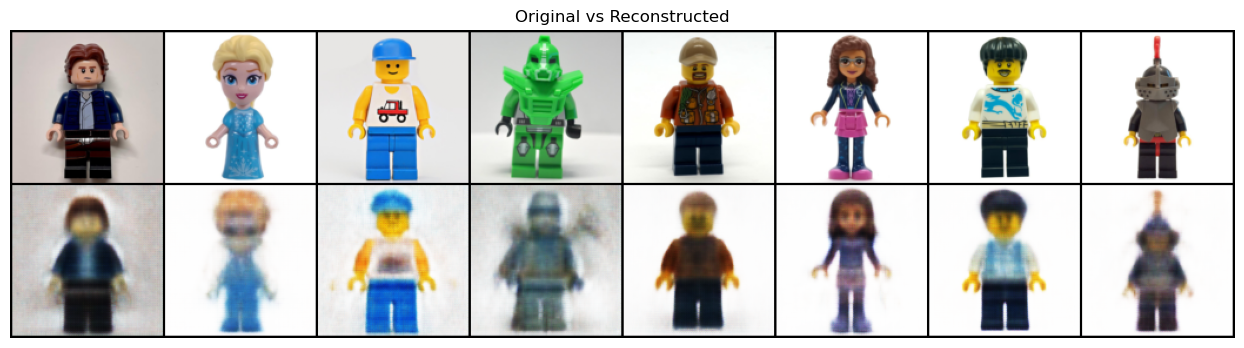

In [138]:
show_result_vae(vae, val_loader, device)

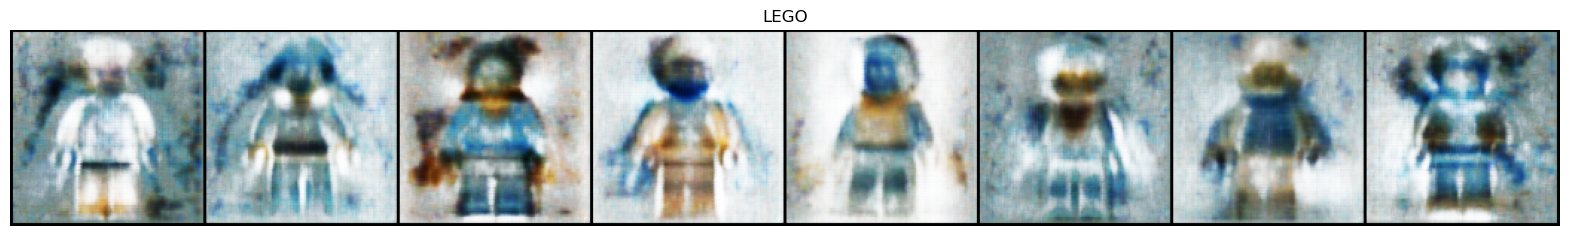

In [168]:
generate_images(vae, device)

In [161]:
torch.save(vae.state_dict(), "vae.pth")
#vae.load_state_dict(torch.load("vae.pth", map_location=device))
#vae.eval